# Trabalho Prático 2

Este notebook aborda o projeto de Machine Learning para construir um sistema de intervenção para estudantes, baseado no dataset UCI Student Performance.

**Objetivo:** Desenvolver um pipeline de machine learning capaz de prever se um estudante passará no exame final (`passed` = 'yes'), permitindo a identificação de alunos que necessitam de atenção e suporte extra.


**Etapas:**
1.  **Setup e Carregamento de Dados:** Importar bibliotecas e carregar o dataset.
2.  **Exploração de Dados (EDA):** Análise inicial para compreender as características do dataset, com foco em visualizações.
3.  **Pré-processamento e Engenharia de Features:** Preparação dos dados para modelagem, incluindo codificação, escalonamento e análise de outliers com PCA.
4.  **Modelação:** Treino e avaliação inicial de modelos de aprendizagem supervisionada.
5.  **Otimização e Avaliação Avançada:** Otimização de hiperparâmetros, tratamento de desbalanceamento de classes e avaliação detalhada.
6.  **Interpretação e Conclusões:** Análise dos resultados, importância das features e conclusões finais.
7.  **(Opcional) Análise de IA Responsável:** Investigação de potenciais vieses.
8.  **(Opcional) Deployment:** Sugestões para deployment.


## Import Bibliotecas

In [3]:
# Bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # Para gráficos interativos
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Pré-processamento e Modelagem
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier # Modelos adicionais
from sklearn.svm import SVC

# Métricas de Avaliação
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, confusion_matrix, roc_curve,
                           classification_report, ConfusionMatrixDisplay)
from sklearn.model_selection import learning_curve  # Corrected import

# Balanceamento de Classes
from imblearn.pipeline import Pipeline as ImbPipeline # Pipeline do imblearn
from imblearn.over_sampling import SMOTE

import warnings

# Configurações
%matplotlib inline
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print('Bibliotecas importadas com sucesso!')


Bibliotecas importadas com sucesso!


## Dataset

In [4]:
# Carregar o dataset
data_path = 'student-data.csv'
df = pd.read_csv(data_path)

# Mapear a variável alvo para binário (0/1)
le = LabelEncoder()
df['passed_numeric'] = le.fit_transform(df['passed'])
# Guardar o mapeamento para referência
target_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Mapeamento da variável alvo 'passed': {target_mapping}")

# Mostrar as primeiras linhas
print("\n--- Primeiras 5 linhas do Dataset ---")
display(df.head())

# Mostrar as dimensões do dataset
print(f"\nDimensões do Dataset: {df.shape[0]} linhas e {df.shape[1]} colunas")

Mapeamento da variável alvo 'passed': {'no': np.int64(0), 'yes': np.int64(1)}

--- Primeiras 5 linhas do Dataset ---


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed,passed_numeric
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,no,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,no,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,yes,1
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,yes,1
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,yes,1



Dimensões do Dataset: 395 linhas e 32 colunas


# Exploração de Dados

In [5]:
print(df['passed'].value_counts())

passed
yes    265
no     130
Name: count, dtype: int64


## Estatisticas Descritivas Basicas

In [6]:
# Calcula estatísticas descritivas para variáveis numéricas
numeric_df = df.select_dtypes(include=['number'])
mean = numeric_df.mean()
median = numeric_df.median()
std_dev = numeric_df.std()
skewness = numeric_df.skew()
kurtosis = numeric_df.kurt()

# Cria uma tabela com as estatísticas descritivas
descriptive_stats = pd.DataFrame({
    'Média': mean,
    'Mediana': median,
    'Desvio Padrão': std_dev,
    'Assimetria': skewness,
    'Curtose': kurtosis
})

# Exibe a tabela
print("\nTabela de Estatísticas Descritivas:\n", descriptive_stats)


Tabela de Estatísticas Descritivas:
                     Média  Mediana  Desvio Padrão  Assimetria    Curtose
age             16.696203     17.0       1.276043    0.466270  -0.001222
Medu             2.749367      3.0       1.094735   -0.318381  -1.090014
Fedu             2.521519      2.0       1.088201   -0.031672  -1.198539
traveltime       1.448101      1.0       0.697505    1.607029   2.344190
studytime        2.035443      2.0       0.839240    0.632142  -0.014432
failures         0.334177      0.0       0.743651    2.387026   5.004727
famrel           3.944304      4.0       0.896659   -0.951882   1.139772
freetime         3.235443      3.0       0.998862   -0.163351  -0.301807
goout            3.108861      3.0       1.113278    0.116502  -0.770250
Dalc             1.481013      1.0       0.890741    2.190762   4.759492
Walc             2.291139      2.0       1.287897    0.611960  -0.790845
health           3.554430      4.0       1.390303   -0.494604  -1.014078
absences     

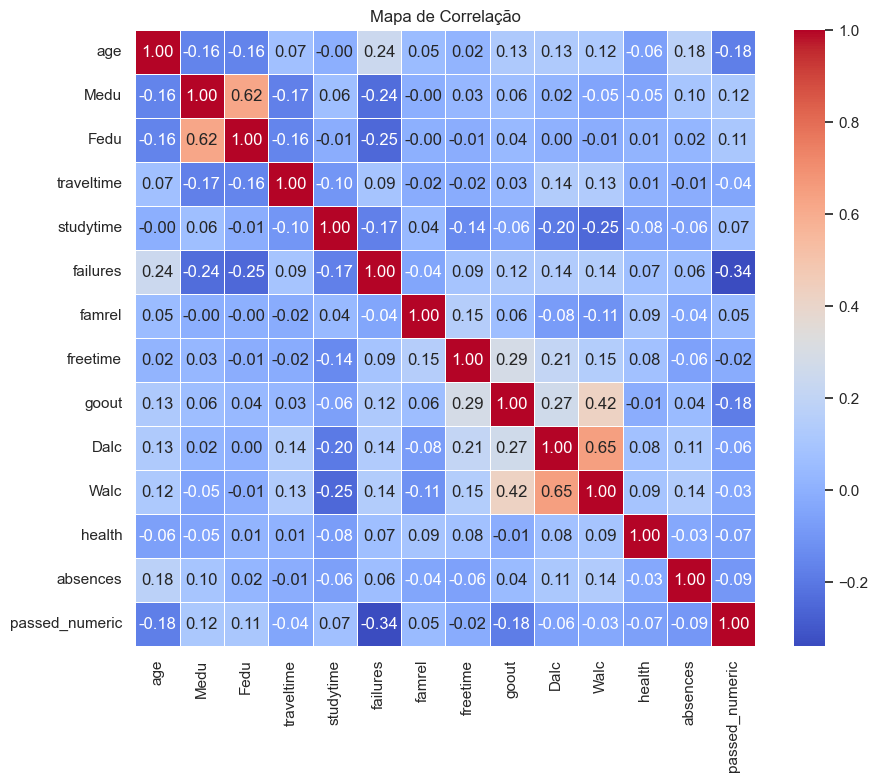

In [7]:
# Calcula a correlação entre as variáveis numéricas e a feature 'passed'
correlation_matrix = numeric_df.corr()

# Faz um mapa de calor para visualizar as correlações
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlação')
plt.show()

In [8]:
from scipy.stats import chi2_contingency

# Seleciona colunas categóricas
categorical_columns = df.select_dtypes(include=['object']).columns

# Conta os valores únicos e exibe os resultados
for col in categorical_columns:
    value_counts = df[col].value_counts()


    # Função para verificar a relação entre variáveis categóricas e a feature 'passed'
    def check_relationship_with_passed(df, categorical_columns):
        for col in categorical_columns:
            contingency_table = pd.crosstab(df[col], df['passed'])
            chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Chama a função para verificar as relações
    check_relationship_with_passed(df, categorical_columns)
    check_relationship_with_passed(df, ['guardian'])
    # Cria uma tabela para apresentar os resultados
    relationship_table = []

    for col in categorical_columns:
        contingency_table = pd.crosstab(df[col], df['passed'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        relationship_table.append({'Variável': col, 'Chi2': chi2, 'p-valor': p, 'Relação Significativa': 'Sim' if p < 0.1 else 'Não'})

    # Converte a lista de resultados em um DataFrame
    relationship_df = pd.DataFrame(relationship_table)

    # Exibe a tabela
    print("\nTabela de Relações entre Variáveis Categóricas e 'passed':\n")
    print(relationship_df)


Tabela de Relações entre Variáveis Categóricas e 'passed':

      Variável        Chi2       p-valor Relação Significativa
0       school    0.206339  6.496520e-01                   Não
1          sex    1.680311  1.948831e-01                   Não
2      address    0.828878  3.625973e-01                   Não
3      famsize    0.508995  4.755743e-01                   Não
4      Pstatus    0.489916  4.839647e-01                   Não
5         Mjob    5.303167  2.575806e-01                   Não
6         Fjob    2.080416  7.209711e-01                   Não
7       reason    4.493738  2.128495e-01                   Não
8     guardian    5.318375  7.000507e-02                   Sim
9    schoolsup    3.330694  6.799817e-02                   Sim
10      famsup    1.138602  2.859480e-01                   Não
11        paid    3.007571  8.287639e-02                   Sim
12  activities    0.019497  8.889514e-01                   Não
13     nursery    0.001761  9.665274e-01                 

## Tratamento de Outliers

Número de outliers por coluna:
 age                1
Medu               0
Fedu               2
traveltime         8
studytime         27
failures          83
famrel            26
freetime          19
goout              0
Dalc              18
Walc               0
health             0
absences          15
passed_numeric     0
dtype: int64
Número de outliers severos por coluna:
 age                0
Medu               0
Fedu               0
traveltime         0
studytime          0
failures          83
famrel             0
freetime           0
goout              0
Dalc               0
Walc               0
health             0
absences           5
passed_numeric     0
dtype: int64


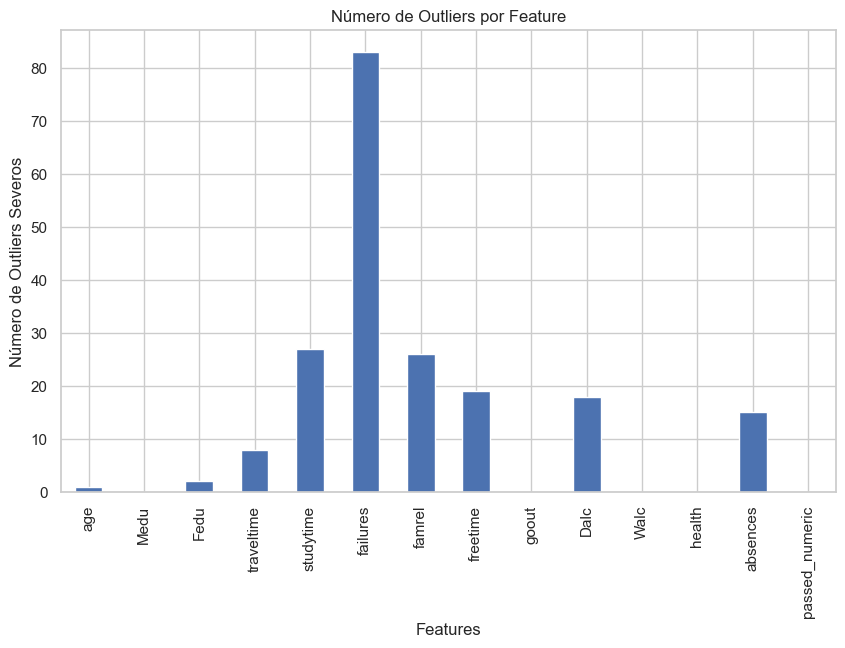

In [9]:
numeric_df = df.select_dtypes(include=['number'])
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_df = df[numeric_cols]

# Identifica outliers usando o método do IQR
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

# Define limites para outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Assinala os outliers por coluna
outliers = ((numeric_df < lower_bound) | (numeric_df > upper_bound))

# Conta o número de outliers por coluna
outliers_count = outliers.sum()
print("Número de outliers por coluna:\n", outliers_count)

# Identifica outliers severos usando o método do IQR
lower_bound_severe = Q1 - 3 * IQR
upper_bound_severe = Q3 + 3 * IQR

# Assinala os outliers severos por coluna
outliers_severe = ((numeric_df < lower_bound_severe) | (numeric_df > upper_bound_severe))

# Conta o número de outliers severos por coluna
outliers_severe_count = outliers_severe.sum()
print("Número de outliers severos por coluna:\n", outliers_severe_count)

# Faz um gráfico de barras com o número de outliers severos por feature
outliers_count.plot(kind='bar', figsize=(10, 6), title='Número de Outliers por Feature')
plt.xlabel('Features')
plt.ylabel('Número de Outliers Severos')
plt.show()

## Identificação dos outliers

In [10]:
# Resolve warnings by explicitly casting mean values to the appropriate dtype
for col in [c for c in numeric_cols if c not in ['failures', 'absences']]:
    non_severe_outliers = (numeric_df[col] < lower_bound[col]) | (numeric_df[col] > upper_bound[col])
    numeric_df.loc[non_severe_outliers, col] = mean[col].astype(numeric_df[col].dtype)

# Exibe o DataFrame após a imputação corrigida
print("DataFrame após imputação dos outliers não severos (corrigido):\n", numeric_df)

DataFrame após imputação dos outliers não severos (corrigido):
      age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  \
0     18     4     4           2          2         0       4         3   
1     17     1     1           1          2         0       5         3   
2     15     1     1           1          2         3       4         3   
3     15     4     2           1          3         0       3         2   
4     16     3     3           1          2         0       4         3   
..   ...   ...   ...         ...        ...       ...     ...       ...   
390   20     2     2           1          2         2       5         5   
391   17     3     1           2          1         0       3         4   
392   21     1     1           1          1         3       5         5   
393   18     3     2           3          1         0       4         4   
394   19     1     1           1          1         0       3         2   

     goout  Dalc  Walc  health  abs

# Algoritmos

In [11]:
scaler = MinMaxScaler()
numeric_scaled_treated = scaler.fit_transform(numeric_df[numeric_cols])
numeric_scaled_original = scaler.fit_transform(df[numeric_cols])

# 9. Aplicação de PCA nos dados com imputação prévia
pca = PCA(n_components=2)
pca_result_treated = pca.fit_transform(numeric_scaled_treated)

# Criar DataFrame com os resultados do PCA (com imputação prévia)
pca_df_treated = pd.DataFrame(data=pca_result_treated, columns=['PC1', 'PC2'])
# Adiciona a coluna 'passed' para análise (assumindo que existe no df original)
pca_df_treated['passed'] = df['passed']

# 10. Aplicação de PCA nos dados originais para comparação
pca_original = PCA(n_components=2)
pca_result_original = pca_original.fit_transform(numeric_scaled_original)

# Criar DataFrame com os resultados do PCA (original)
pca_df_original = pd.DataFrame(data=pca_result_original, columns=['PC1', 'PC2'])
pca_df_original['passed'] = df['passed']

# 11. Visualização comparativa dos resultados PCA
plt.figure(figsize=(14, 6))

# Subplot para dados originais
plt.subplot(1, 2, 1)
sns.scatterplot(data=pca_df_original, x='PC1', y='PC2', hue='passed', palette='viridis', alpha=0.7)
plt.title('PCA - Sem Tratamento de Outliers')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Passou')

# Subplot para dados com imputação prévia
plt.subplot(1, 2, 2)
sns.scatterplot(data=pca_df_treated, x='PC1', y='PC2', hue='passed', palette='viridis', alpha=0.7)
plt.title('PCA - Com Imputação Prévia')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Passou')

plt.tight_layout()
plt.show()

NameError: name 'MinMaxScaler' is not defined

In [162]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

# Separar as features e o target
X = numeric_scaled_original  # Dados sem tratamento de outliers
y = df['passed']  # Target

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criar o modelo SVM
svm_model = SVC(kernel='linear', random_state=42)

# Treinar o modelo
svm_model.fit(X_train, y_train)

# Fazer previsões
y_pred = svm_model.predict(X_test)

# Avaliar o modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

# Verificar a distribuição das classes
print(y.value_counts())

# Validação cruzada para evitar erro de divisão de dados
scores = cross_val_score(svm_model, X, y, cv=5)
print("Validação cruzada acurácias:", scores)
print("Validação cruzada média de acurácia:", np.mean(scores))

Acurácia: 1.0

Relatório de Classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        73

    accuracy                           1.00       119
   macro avg       1.00      1.00      1.00       119
weighted avg       1.00      1.00      1.00       119

passed
1    265
0    130
Name: count, dtype: int64
Validação cruzada acurácias: [1. 1. 1. 1. 1.]
Validação cruzada média de acurácia: 1.0
